#Demo NeuroEvolution usando NEAT-Python para generar una RNA MLP que pueda aprender a clasificar (atributo clase discreto) o estimar (atributo clase continuo)

Con NEAT-Python se busca optimizar la topoloǵía de la red y sus pesos de las conexiones para un conjunto de datos, pero sin entrenar la red (los pesos se definen incialmente al azar y luego se "evolucionan"). Por esto último no utiliza modelos de tipo Keras / TensorFlow por lo que la red generada no es compatible con modelos creados con esa tecnología.

Fuente: https://github.com/CodeReclaimers/neat-python


In [1]:
#@title Cambia a Keras 2 para compatbilidad con la librería TFNE
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip install tf-keras~=2.16

In [2]:
#@title Instalar NEAT-Python
!pip install neat-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.4 MB/s eta 0:00:00


In [3]:
#@title Librerías a usar

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

import os
import csv

import neat

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output
import random
import math


import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import copy
from neat.graphs import required_for_output

import tempfile
from PIL import Image

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [4]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [5]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [6]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [7]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
##  y_trainEnc =  to_categorical(y_train)
##  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 37
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 38

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 13
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 12


# Modelo:

In [8]:
#@title Definir Clase NEAT_NN_Model con Función de Aptitud

if esProblemaClasificacion:
    # para problema de clasificación
    print("-Configurado para problema de Clasificación.")
    # Initialize loss function to evaluate performance on either evaluation method
    fitness_accuracy_metric = tf.keras.metrics.Accuracy()
    umbral_clasificacion = 0.5
else:
    # para problema de Estimación
    print("-Configurado para problema de Estimación.")
    # Initialize loss function to evaluate performance on either evaluation method
    fitness_accuracy_metric = tf.keras.metrics.R2Score()
    umbral_clasificacion = -1

# determina neuronas de entrada y salida
RNA_cantX = x_train.shape[1]
RNA_cantY = 1 # # siempre devuelve uno (no usa softmax data_y.shape[1])
tipo_output_softMax = False

# prepara datos para calculo fitness
x_eval = np.array(x_train).reshape(len(x_train), RNA_cantX)
y_eval = np.array(y_train).reshape(len(y_train), RNA_cantY)
cantClases = len(CLASES)

# define parámetros fitness
ce_max_fitness = 100.0
ce_fitness_criterion = "max" # (maximiza)

print(" Función de Aptitud : ")
print("\t -Criterio: ", ce_fitness_criterion)
print("\t -Máximo: ", ce_max_fitness)
print("\n")
print(" Topología base de la red: ")
print("\t -Capa Entrada: ", RNA_cantX,  " / x_eval: ",  x_eval.shape)
print("\t -Capa Salida: ", RNA_cantY,  " / y_eval " ,  y_eval.shape)
print("\n")

# clase wrapper auxiliar para encapsular ejecución del modelo y cálculo del fitness
class NEAT_NN_Model():

    # inicializa wrapper
    def __init__(self, genome, config, **kwargs):
      self._genome = genome
      self._genomePruned = None
      self._config = config
      self._net = neat.nn.FeedForwardNetwork.create(genome, config)

    # ejecuta el modelo usando todos los dataX
    def predict(self, dataX, verbose=0):
      resY = []
      for x in dataX:
        resY.append( self._net.activate(x) )
      return np.array(resY)

    # función de aptitud
    def calc_fitness(self, x_eval, y_eval, fitness_accuracy_metric, umbral_clasificacion=0.5, cantClases = -1):
      try:
        # calcula con datos de evaluación (definidas antes)
        if (len(x_eval)>0) and (len(y_eval)>0):
          # ejecuta modelo con datos de evaluación
          y_model = self.predict(x_eval)
          if umbral_clasificacion >= 0.0:
            # si es clasificacion tiene que redondear a clase entera
            for i in range(len(y_model)):
              res = y_model[i]
              resRnd = int(res)
              if ((res - resRnd)>umbral_clasificacion) and ((resRnd+1)<cantClases):
                  y_model[i] = resRnd + 1
          # calcula métrica
          fitness_accuracy_metric.reset_state()
          fitness_accuracy_metric.update_state(y_eval, y_model)
          valAcc = fitness_accuracy_metric.result().numpy()
          if math.isnan(valAcc):
            evaluated_fitness = 0.0001
          elif valAcc <= 0:
            evaluated_fitness = 0.0002
          else:
            evaluated_fitness = round(valAcc* 100.0, 4)
        else:
          evaluated_fitness = 0.0001
        return round(evaluated_fitness, 5)
      except Exception as e:
        print("Error calculate_fitness: ", e)
        return 0.0001

    def _recorre(self, key, connections_fmt, used_nodes_keys):
      listaOK = []
      if key in connections_fmt:
        # recorre desde nodo key a todos los que puede ir
        for auxKey in connections_fmt[key]:
          if (auxKey in used_nodes_keys) or (auxKey in listaOK):
            # si encontro alguna ya usada
            # quiere decir que es válido
            listaOK.append(auxKey)
          else:
            # recorre desde ese nodo a ver si llega
            auxList = self._recorre(auxKey, connections_fmt, used_nodes_keys)
            if len(auxList)>0:
              # encontro OK,
              listaOK.append( auxKey )
              listaOK.extend( auxList )
      return listaOK

    def genome_get_pruned_copy(self):
        # limpia el genoma eliminando nodos y conexiones redundantes y/o inactivas
        # para ello analiza las conexiones desde nodo salida al nodos de entrada para ver si existe camino
        # primero, formatea conexiones para usar las más fácil
        connections_fmt = {}
        for key, cg in self._genome.connections.items():
          if cg.enabled:
            a, b = key
            if a not in connections_fmt:
              connections_fmt[a] = []
            connections_fmt[a].append(b)
        # luego recorre desde nodo inputs a ver si se llega a output
        # (va anotando nodos usados en lista inicializada por nodos salida)
        used_nodes_keys = list(self._config.genome_config.output_keys)
        for inputKey in self._config.genome_config.input_keys:
          if inputKey not in used_nodes_keys:
            # lo agrega porque es de entrada
            used_nodes_keys.append( inputKey )
          # recorre desde nodo inicial y agrega nodos usados
          used_nodes_keys.extend( self._recorre(inputKey, connections_fmt, used_nodes_keys)  )
        # elimina posibles duplicados
        used_nodes_keys = list(set(used_nodes_keys))
        ###print(used_nodes_keys)
        # genera copias de los nodos usados
        used_node_genes = {}
        for n in used_nodes_keys:
          if n in self._genome.nodes:
            used_node_genes[n] = copy.deepcopy(self._genome.nodes[n])
        # genera copias de conexiones usadas
        used_connection_genes = {}
        for key, cg in self._genome.connections.items():
            # determina nodos conexión
            in_node_id, out_node_id = key
            # si la conexión está habilitada y los nodos se usan
            if cg.enabled and (in_node_id in used_nodes_keys) and (out_node_id in used_node_genes):
                used_connection_genes[key] = copy.deepcopy(cg)
        new_genome = neat.DefaultGenome(None)
        new_genome.nodes = used_node_genes
        new_genome.connections = used_connection_genes
        return new_genome


    def draw_net(self, view=False, show_disabled=True, prune_unused=False):
        """ Receives a genome and draws a neural network with arbitrary topology. """
        # Attributes for network nodes.
        if graphviz is None:
            warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
            return
        # dermina configuracion
        config = self._config
        # If requested, use a copy of the genome which omits all components that won't affect the output.
        if prune_unused:
            if self._genomePruned is None:
              self._genomePruned = self.genome_get_pruned_copy()
            genome = self._genomePruned
        else:
            genome = self._genome
        node_names = {}
        # atributos por defecto
        input_attrs = {'fontsize': '12', 'height': '0.5', 'width': '0.5',
                       'style': 'filled', 'shape': 'box', 'fillcolor': 'lightgray'}
        input_node_attrs = {'style': 'filled', 'fillcolor': 'lightgray'}
        output_attrs = {'fontsize': '12', 'height': '0.5', 'width': '0.5',
                        'style': 'filled', 'shape': 'box', 'fillcolor': 'lightblue'}
        output_node_attrs = {'style': 'filled', 'fillcolor': 'lightblue'}
        node_attrs = {'style': 'filled', 'fillcolor': 'white'}
        # genera diagrama
        dot = graphviz.Digraph(format='png',
                               node_attr={
                                        'shape': 'circle',
                                        'fontsize': '14',
                                        'height': '1.0',
                                        'width': '1.0'})
        # inicializa entradas
        i = 1
        if len(config.genome_config.input_keys)==1:
          node_names[ config.genome_config.input_keys[0] ] = "Ne"
        inputs = set()
        for k in config.genome_config.input_keys:
            inputs.add(k)
            if k not in node_names:
              # si no está le agrega nombre por defecto
              node_names[k] = "Ne"+str(i)
              nameX = "x"+str(i)
              i+=1
            else:
              nameX = "x"
            nameNode = node_names[k]
            # agrega valor entrada
            dot.node(nameX, _attributes=input_attrs)
            # agrega neurona entrada
            dot.node(nameNode, _attributes=input_node_attrs)
            # agrega conexion entre ellas
            dot.edge(nameX, nameNode, _attributes={'style': 'solid', 'color': 'gray', 'penwidth': '1.0'})
        # inicializa salidas
        i = 1
        if len(config.genome_config.output_keys)==1:
          node_names[ config.genome_config.output_keys[0] ] = "Ns"
        outputs = set()
        for k in config.genome_config.output_keys:
            outputs.add(k)
            if k not in node_names:
              # si no está le agrega nombre por defecto
              node_names[k] = "Ns"+str(i)
              nameY = "y"+str(i)
              i+=1
            else:
              nameY = "y"
            nameNode = node_names[k]
            # agrega neurona salida
            dot.node(nameNode, _attributes=output_node_attrs)
            # agrega valor salida
            dot.node(nameY, _attributes=output_attrs)
            # agrega conexion entre ellas
            dot.edge(nameNode, nameY, _attributes={'style': 'solid', 'color': 'blue', 'penwidth': '1.0'})
        # inicializa neuronas
        i = 1
        used_nodes = set(genome.nodes.keys())
        for n in used_nodes:
            if n in inputs or n in outputs:
                continue
            if n not in node_names:
              # si no está le agrega nombre por defecto
              node_names[n] = "No"+str(i)
              i+=1
            name = node_names[k]
            dot.node(name, _attributes=node_attrs)
        # inicializa conexiones
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                # if cg.input not in used_nodes or cg.output not in used_nodes:
                #    continue
                input, output = cg.key
                a = node_names.get(input, str(input))
                b = node_names.get(output, str(output))
                style = 'solid' #if cg.weight > 0 else 'dotted'
                color = 'green' if cg.enabled else 'red'
                width = str(min(10.0, 0.1 + abs(cg.weight*2)))
                dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})
        # renderiza gráfico
        auxFile = dot.render(None, view=view)
        if view:
          display(Image.open(auxFile))
          print("\nGenoma:")
          ##print(self._genome)
          ##print("")
          print("-Key: ", self._genome.key)
          print("-Fitness: ", self._genome.fitness)
          print("-Neuronas:")
          nodes = self._genome.nodes.items()
          for k, ng in nodes:
            if k in node_names:
              print("   " + node_names.get(k, str(k)) + " : " + str(ng))
          print("-Conexiones:")
          connections = list(self._genome.connections.values())
          connections.sort()
          lines = [ "", "" ]
          for cg in connections:
            input, output = cg.key
            if (input in node_names) and (output in node_names):
              a = node_names.get(input, str(input))
              b = node_names.get(output, str(output))
              line = "\t" + a + "-->" + b + " : " + str(cg) + "\n"
              if cg.enabled:
                lines[0] = lines[0] + line
              else:
                lines[1] = lines[1] + line
          if len(lines[0]) > 0:
            print("   Activas:\n" + lines[0], end="")
          if len(lines[1]) > 0:
            print("   Inactivas:\n" + lines[1], end="")
          print("")
        return dot



# función para procesar todos los genomas de una población
def eval_genomes(genomes, config):
  global umbral_clasificacion, cantClases
  global fitness_accuracy_metric
  global x_eval, y_eval
  for genome_id, genome in genomes:
        model = NEAT_NN_Model(genome, config)
        genome.fitness = model.calc_fitness(x_eval, y_eval,
                                            fitness_accuracy_metric,
                                            umbral_clasificacion, cantClases)

print("Función de aptitud definida.")

-Configurado para problema de Clasificación.
 Función de Aptitud : 
	 -Criterio:  max
	 -Máximo:  100.0


 Topología base de la red: 
	 -Capa Entrada:  4  / x_eval:  (112, 4)
	 -Capa Salida:  1  / y_eval  (112, 1)


Función de aptitud definida.


In [9]:
#@title Crear Archivo Configuración de Parámetros para NEAT-Python

#@markdown Generales:
ce_tamanio_poblacion = 50 #@param {type:"integer"}
#@markdown Criterio de Paro:
ce_maximo_generaciones_procesar = 250 #@param {type:"integer"}
ce_finalizar_al_encontrar_max_fitness = True #@param {type:"boolean"}
#@markdown Reproducción:
ce_cant_mejores_individuos_pasa_sigte_generacion = 2 #@param {type:"integer"}
ce_probabilidad_cruzamiento = 1.0 #@param {type:"number"}
ce_cant_minima_individuos_hijos_generar = ce_tamanio_poblacion // 10
if  ce_cant_minima_individuos_hijos_generar < 2:
  ce_cant_minima_individuos_hijos_generar = 2
#@markdown Genoma:
ce_funcion_aptitud_probab_mutar = 0.5 #@param {type:"number"}
ce_agregar_conexiones_probab_mutar = 0.8 #@param {type:"number"}
ce_borrar_conexiones_probab_mutar = 0.4 #@param {type:"number"}
ce_agregar_nodes_probab_mutar = 0.6 #@param {type:"number"}
ce_borrar_nodes_probab_mutar = 0.3 #@param {type:"number"}

# explicación detallada de parámetros en https://neat-python.readthedocs.io/en/latest/config_file.html
config_FileName = './codeepneat_config.cfg'

s = ""
with open(config_FileName, 'w') as f:
    s = s + "\n"
    s = s + "[NEAT]\n"
    s = s + "fitness_criterion     = " + ce_fitness_criterion + "\n"
    if ce_finalizar_al_encontrar_max_fitness:
      s = s + "no_fitness_termination   = False\n"
      s = s + "fitness_threshold     = " + str(ce_max_fitness-0.09) + "\n"
    else:
      s = s + "no_fitness_termination   = True\n"
    if ce_tamanio_poblacion < 2:
      ce_tamanio_poblacion = 2
    s = s + "pop_size              = " + str(ce_tamanio_poblacion) + "\n"
    # when all species simultaneously become extinct due to stagnation, a new random population will be created.
    s = s + "reset_on_extinction   = True\n"
    s = s + "\n"
    s = s + "[DefaultGenome]\n"
    # node function activation options
    s = s + "activation_default      = random\n"
    if (ce_funcion_aptitud_probab_mutar<0.0):
      ce_funcion_aptitud_probab_mutar = 0
    elif (ce_funcion_aptitud_probab_mutar>1.0):
      ce_funcion_aptitud_probab_mutar = 1.0
    s = s + "activation_mutate_rate  = " + str(ce_funcion_aptitud_probab_mutar) + "\n"
    s = s + "activation_options      = sigmoid abs exp gauss identity relu softplus tanh square\n"
    s = s + "\n"
    # node aggregation options  (se deja por defecto siempre)
    s = s + "aggregation_default     = random\n"
    s = s + "aggregation_mutate_rate = 0.2\n"
    s = s + "aggregation_options     = sum product min max mean median maxabs\n"
    s = s + "\n"
    # node bias options (se deja por defecto siempre)
    s = s + "bias_init_mean          = 0.0\n"
    s = s + "bias_init_stdev         = 1.0\n"
    s = s + "bias_max_value          = 30.0\n"
    s = s + "bias_min_value          = -30.0\n"
    s = s + "bias_mutate_power       = 0.5\n"
    s = s + "bias_mutate_rate        = 0.7\n"
    s = s + "bias_replace_rate       = 0.1\n"
    s = s + "\n"
    # genome compatibility options (se deja por defecto siempre)
    s = s + "compatibility_disjoint_coefficient = 1.0\n"
    s = s + "compatibility_weight_coefficient   = 0.5\n"
    s = s + "\n"
    # connection add/remove rates
    if (ce_agregar_conexiones_probab_mutar<0.0):
      ce_agregar_conexiones_probab_mutar = 0
    elif (ce_agregar_conexiones_probab_mutar>1.0):
      ce_agregar_conexiones_probab_mutar = 1.0
    s = s + "conn_add_prob           = " + str(ce_agregar_conexiones_probab_mutar) + "\n"
    if (ce_borrar_conexiones_probab_mutar<0.0):
      ce_borrar_conexiones_probab_mutar = 0
    elif (ce_borrar_conexiones_probab_mutar>1.0):
      ce_borrar_conexiones_probab_mutar = 1.0
    s = s + "conn_delete_prob        = " + str(ce_borrar_conexiones_probab_mutar) + "\n"
    s = s + "\n"
    # connection enable options (se deja por defecto siempre)
    s = s + "enabled_default         = True\n"
    s = s + "enabled_mutate_rate     = 0.05\n"
    s = s + "\n"
    s = s + "feed_forward            = True\n"
    s = s + "initial_connection      = full\n"
    s = s + "\n"
    # node add/remove rates (se deja por defecto siempre)
    if (ce_agregar_nodes_probab_mutar<0.0):
      ce_agregar_nodes_probab_mutar = 0
    elif (ce_agregar_nodes_probab_mutar>1.0):
      ce_agregar_nodes_probab_mutar = 1.0
    s = s + "node_add_prob           = " + str(ce_agregar_nodes_probab_mutar) + "\n"
    if (ce_borrar_nodes_probab_mutar<0.0):
      ce_borrar_nodes_probab_mutar = 0
    elif (ce_borrar_nodes_probab_mutar>1.0):
      ce_borrar_nodes_probab_mutar = 1.0
    s = s + "node_delete_prob        = " + str(ce_borrar_nodes_probab_mutar) + "\n"
    s = s + "\n"
    # network parameters (se deja por defecto siempre)
    s = s + "num_hidden              = 0\n"
    s = s + "num_inputs              = " + str(RNA_cantX) + "\n"
    s = s + "num_outputs             = " + str(RNA_cantY) + "\n"
    s = s + "\n"
    # node response options (se deja por defecto siempre)
    s = s + "response_init_mean      = 1.0\n"
    s = s + "response_init_stdev     = 0.0\n"
    s = s + "response_max_value      = 30.0\n"
    s = s + "response_min_value      = -30.0\n"
    s = s + "response_mutate_power   = 0.0\n"
    s = s + "response_mutate_rate    = 0.0\n"
    s = s + "response_replace_rate   = 0.0\n"
    s = s + "\n"
    # connection weight options (se deja por defecto siempre
    s = s + "weight_init_mean        = 0.0\n"
    s = s + "weight_init_stdev       = 1.0\n"
    s = s + "weight_max_value        = 30\n"
    s = s + "weight_min_value        = -30\n"
    s = s + "weight_mutate_power     = 0.5\n"
    s = s + "weight_mutate_rate      = 0.8\n"
    s = s + "weight_replace_rate     = 0.1\n"
    s = s + "\n"
    # Individuals whose genomic distance is less than this threshold are considered to be in the same species (se deja por defecto siempre
    s = s + "[DefaultSpeciesSet]\n"
    s = s + "compatibility_threshold = 3.0\n"
    s = s + "\n"
    # parámetros para eliminación automática de 'especies' que no mejoran
    s = s + "[DefaultStagnation]\n"
    s = s + "species_fitness_func = " + ce_fitness_criterion + "\n"
    s = s + "max_stagnation       = " + str(ce_maximo_generaciones_procesar//2) + "\n"
    s = s + "species_elitism      = 2\n"
    s = s + "\n"
    s = s + "[DefaultReproduction]\n"
    if ce_cant_mejores_individuos_pasa_sigte_generacion < 0:
      ce_cant_mejores_individuos_pasa_sigte_generacion = 0
    s = s + "elitism            = " + str(ce_cant_mejores_individuos_pasa_sigte_generacion) + "\n"
    if (ce_probabilidad_cruzamiento<0.0):
      ce_probabilidad_cruzamiento = 0
    elif (ce_probabilidad_cruzamiento>1.0):
      ce_probabilidad_cruzamiento = 1.0
    s = s + "survival_threshold = " + str(ce_probabilidad_cruzamiento) + "\n"
    if ce_cant_minima_individuos_hijos_generar < 2:
      ce_cant_minima_individuos_hijos_generar = 2
    s = s + "min_species_size = " + str(ce_cant_minima_individuos_hijos_generar) + "\n"
    s = s + "\n"
    f.write(s)

# muestra nuevo archivo modificado
%cat {config_FileName}


[NEAT]
fitness_criterion     = max
no_fitness_termination   = False
fitness_threshold     = 99.91
pop_size              = 50
reset_on_extinction   = True

[DefaultGenome]
activation_default      = random
activation_mutate_rate  = 0.5
activation_options      = sigmoid abs exp gauss identity relu softplus tanh square

aggregation_default     = random
aggregation_mutate_rate = 0.2
aggregation_options     = sum product min max mean median maxabs

bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

conn_add_prob           = 0.8
conn_delete_prob        = 0.4

enabled_default         = True
enabled_mutate_rate     = 0.05

feed_forward            = True
initial_connection      = full

node_add_prob           = 0.6
node_delete_prob        = 0.3

num_hid

In [10]:
#@title Ejecutar NeuroEvolution con NEAT-Python


# función auxiliar para ejecutar neuroevolucion
def run(config, N_generations=10):

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to N generations.
    if N_generations < 1:
      N_generations = 1
    winner = p.run(eval_genomes, (N_generations+1))

    # Display the winning genome.
    print('\n>Best genome:\n{!s}'.format(winner))
    winner_model = NEAT_NN_Model(winner, config)

    return winner, winner_model, stats


# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                      neat.DefaultSpeciesSet, neat.DefaultStagnation,
                      config_FileName)
# Ejecuta NEAT
win_genome, model, stats = run(config, ce_maximo_generaciones_procesar)



 ****** Running generation 0 ****** 



<ipython-input-8-a44ea9d9e08c>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resRnd = int(res)


Se han truncado las últimas 5000 líneas del flujo de salida.
     3    6     5     33.0    0.194     3
     4    4     8     38.4    0.151     2
     5    1     5      0.0    0.000     0
Total extinctions: 0
Generation time: 0.229 sec (0.296 average)

 ****** Running generation 9 ****** 

Population's average fitness: 9.48229 stdev: 16.39632
Best fitness: 52.67860 - size: (1, 2) - species 1 - id 306
Average adjusted fitness: 0.186
Mean genetic distance 2.816, standard deviation 0.639
Population of 50 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9    13     52.7    0.119     8
     2    9    12     33.0    0.314     9
     3    7    11     33.0    0.251     4
     4    5    11     38.4    0.248     3
     5    2     3      0.0    0.000     1
Total extinctions: 0
Generation time: 0.224 sec (0.289 average)
Saving checkpoint to neat-checkpoint-9

 ****** Running generation 10 ****** 

Population's average fitness: 11.42

Mejor RNA generada: 


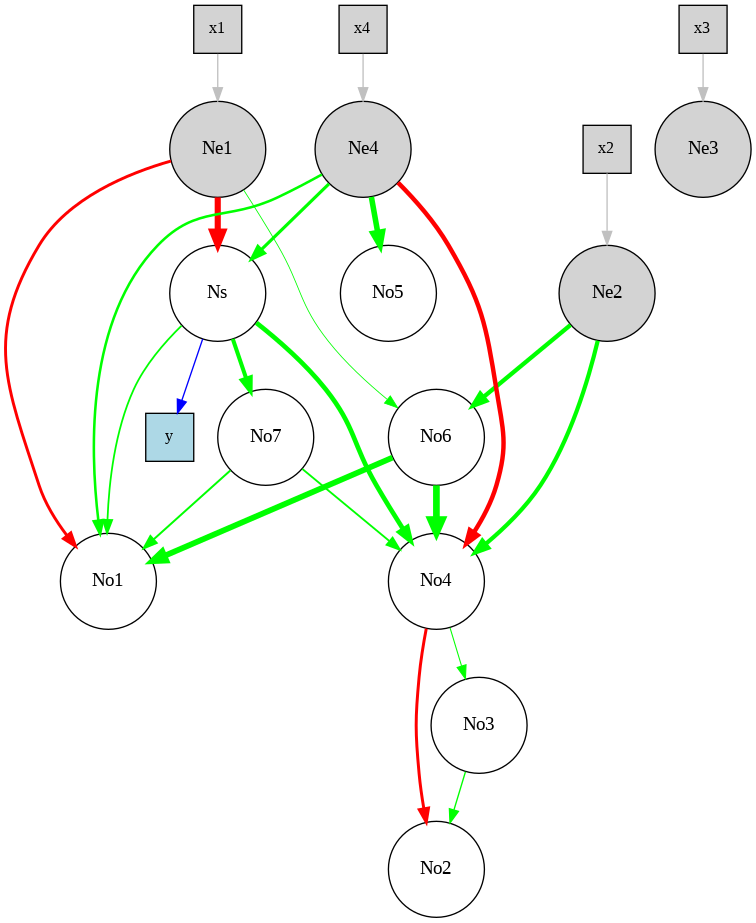


Genoma:
-Key:  7471
-Fitness:  78.5714
-Neuronas:
   Ns : DefaultNodeGene(key=0, bias=0.3959559397591168, response=1.0, activation=relu, aggregation=product)
   No2 : DefaultNodeGene(key=196, bias=-1.2377179238792864, response=1.0, activation=exp, aggregation=maxabs)
   No4 : DefaultNodeGene(key=463, bias=0.02337336603962803, response=1.0, activation=softplus, aggregation=max)
   No1 : DefaultNodeGene(key=1857, bias=2.0125293125469743, response=1.0, activation=exp, aggregation=min)
   No5 : DefaultNodeGene(key=2640, bias=1.7669484795248216, response=1.0, activation=softplus, aggregation=product)
   No7 : DefaultNodeGene(key=2687, bias=-1.0258608599375134, response=1.0, activation=tanh, aggregation=product)
   No6 : DefaultNodeGene(key=2735, bias=2.47039349706631, response=1.0, activation=softplus, aggregation=max)
   No3 : DefaultNodeGene(key=4422, bias=1.0348741810998512, response=1.0, activation=square, aggregation=product)
-Conexiones:
   Activas:
	Ne4-->Ns : DefaultConnectionGene(

In [11]:
#@title Mostrar mejor RNA generada por NeuroEvolution

eliminar_conexiones_y_nodos_redundantes = False #@param {type:"boolean"}

print("Mejor RNA generada: ")
d = model.draw_net(view=True,
                   show_disabled=not(eliminar_conexiones_y_nodos_redundantes),
                   prune_unused=eliminar_conexiones_y_nodos_redundantes)


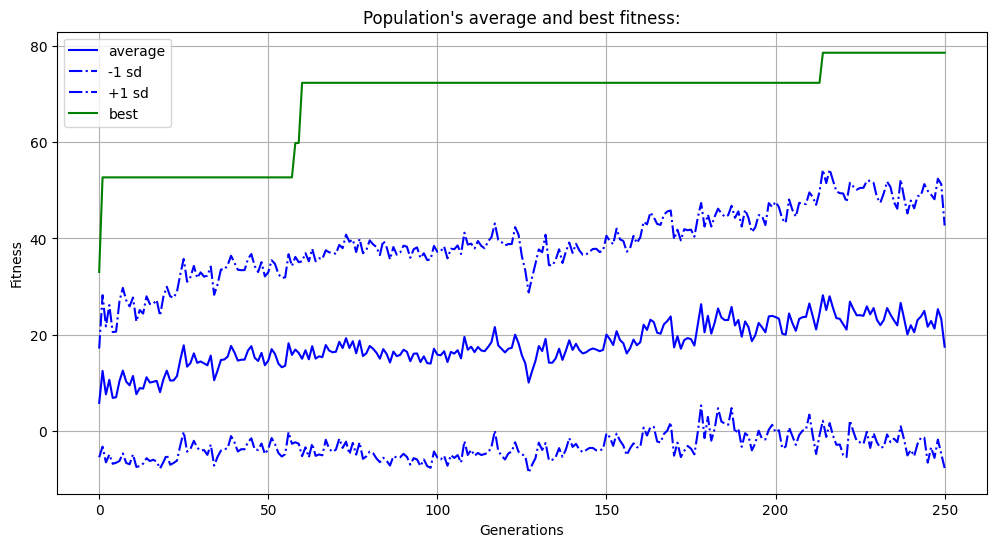

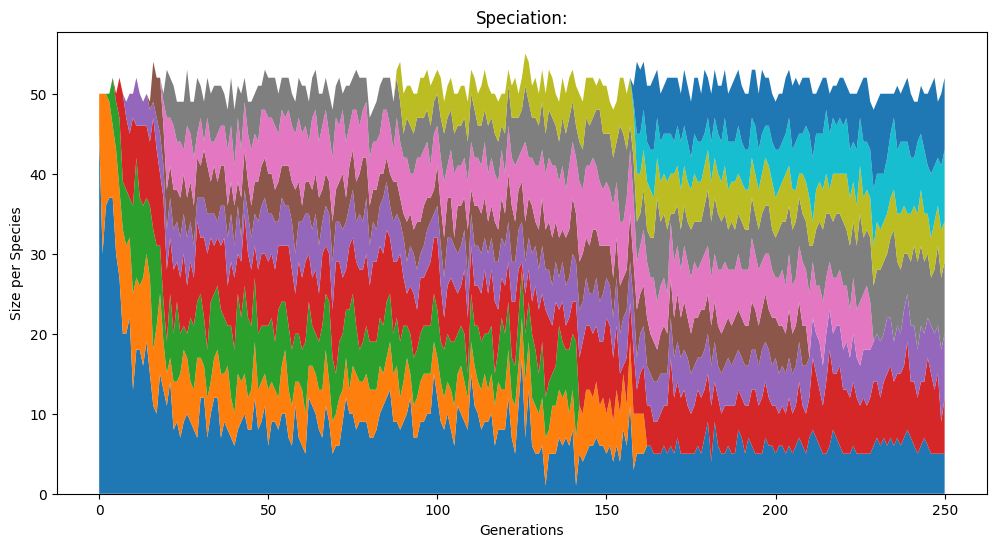

In [12]:
#@title Motrar estadísticas de la ejecución de NeuroEvolution


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.figure(figsize=(12,6))
    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'b-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'b-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'g-', label="best")

    plt.title("Population's average and best fitness:")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T


    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation:")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()

print("")
plot_stats(stats, ylog=False, view=True)
print("")
plot_species(stats, view=True)

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        37
  Versicolor       0.77      1.00      0.87        37
   Virginica       1.00      0.71      0.83        38

    accuracy                           0.90       112
   macro avg       0.92      0.90      0.90       112
weighted avg       0.92      0.90      0.90       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            37             0            0     0
r:Versicolor         0            37            0     0
r:Virginica          0            11           27     0
r:na                 0             0            0     0




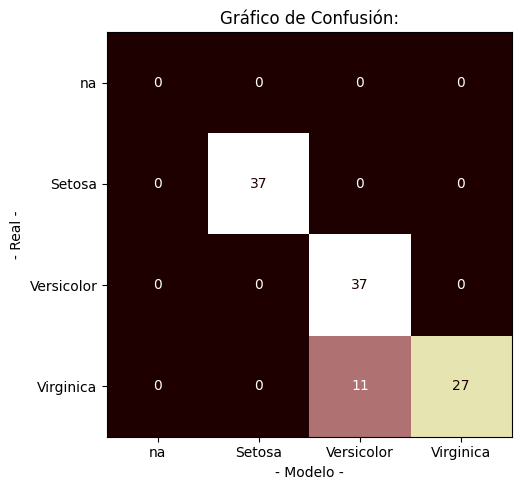

In [13]:
#@title Evaluar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]
  [6.4 2.8 5.6 2.1]-> R: Virginica / M: Virginica [ OK ]
  [4.6 3.6 1.  0.2]-> R: Setosa / M: Setosa [ OK ]
  [4.9 2.4 3.3 1. ]-> R: Versicolor / M: Versicolor [ OK ]
  [5.5 2.5 4.  1.3]-> R: Versicolor / M: Versicolor [ OK ]
  [6.2 2.9 4.3 1.3]-> R: Versicolor / M: Versicolor [ OK ]
  [6.7 3.3 5.7 2.1]-> R: Virginica / M: Virginica [ OK ]
  [5.1 3.5 1.4 0.2]-> R: Setosa / M: Setosa [ OK ]
  [6.7 3.  5.  1.7]-> R: Versicolor / M: Versicolor [ OK ]
  [7.2 3.2 6.  1.8]-> R: Virginica / M: Versicolor [ ERROR! ]
  [6.3 2.7 4.9 1.8]-> R: Virginica / M: Versicolor [ ERROR! ]
  [5.9 3.  4.2 1.5]-> R: Versicolor / M: Versicolor [ OK ]
  [5.8 2.8 5.1 2.4]-> R: Virginica / M: Virginica [ OK ]
  [6.  2.9 4.5 1.5]-> R: Versicolor / M: Versicolor [ OK ]
  [6.3 3.4 5.6 2.4]-> R: Virginica / M: Virginica [ OK ]
  [6.2 2.2 4.5 1.5]-> R: Versicolor / M: Versicolor [ OK ]
  [5.4 3.4 1.7 0.2]-> R: Setosa / M: 

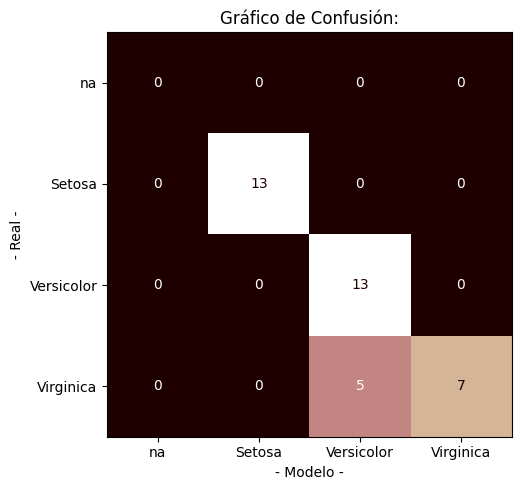

In [14]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [15]:
#@title Guardar Modelo

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/datosNEATPython'  #@param {type:"string"}

if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/RNA-NeuroEvolucion.joblib"
    joblib.dump(model, fn_modelo)
    print("\n-RNA evolucionada guardada en ", fn_modelo,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-RNA evolucionada guardada en  /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/datosNEATPython/RNA-NeuroEvolucion.joblib 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoCESwarm/NeuroEvolution/modelos/datosNEATPython/CLASES_MAP.txt 

